### An exploration of airbnb listings from October 11 2020 in Seattle, WA

##### Analysis Questions:
- How much could I rent my own studio for?
- Which neighborhood has the highest rentals?
- Are the highest rated hosts the most responsive to customers?
- Most common words in rental descriptions
- Are experienced hosts more highly reviewed? Do they charge more?

##### More questions:
- Maximum profit is a balance  of charging a price that is high as possible and also maintaining a booking frequency that is as high as possible (the intersection of the price+demand curve)
- Airbnbs that are constantly booked should increase their cost while airbnbs that struggle to book should decrease
- Which airbnbs are overpriced? (are under booked, could make more money if they lowered their price)
- Which airbnbs are underpriced?
- Which airbnbs are highly profitable and have inelastic demand? (Can charge a lot but still get booked because they are adjacent to tourist destinations, etc)
- How does a host's rating effect the price+demand curve?
- At which point do lower ratings really destroy your competitiveness as a host?

### Analysis Plan 1:
- The demand curve is defined with price on the y axis, and quantity sold on the x axis
- What if we generated an adapted demand curve: y axis = value, x axis = % of time booked
- Value ~=~ appeal of rental (based on features) / price of rental
- ^ Is the value curve linear? Is it predictable? Where are there deviations from this curve?
- Is the relationship between value and % of days booked linear?
- FIRST STEP: generate regression model between features and price, --> this will be the value curve
- SECOND STEP: Is there a correlation (relationship) between value and % of time booked

#### Analysis Plan 2:
- Use (linear) regression to predict price from features
- Airbnbs that charge a lower price than our model predicts are considered HIGHER value (a great deal)
- Airbnbs that cost more than our model predicts are considered LOW value (a bad deal)
- Each rental will get assigned a value score
- Then we will assess the relationship between VALUE SCORE and % days booked (quantity sold)
- Are the high value airbnbs always booked compared to the low value ones?
- If an airbnb is always booked, it should increase its prices to MAXIMIZE REVENUE
- If an airbnb is under booked, it should decrease its prices to MAXIMIZE REVENUE
- Which airbnbs should adjust their prices to increase their revenue?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Import data of airbnb listings in Seattle

temp_df = pd.read_csv('listings.csv.gz', compression='gzip',
                   error_bad_lines=False)

print(temp_df.shape)
temp_df.head(1)

(8695, 96)


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (87) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2318,https://www.airbnb.com/rooms/2318,20181011130926,2018-10-11,"Casa Madrona - Urban Oasis, 1 block from the P...","Gorgeous, architect remodeled, 1917 Dutch Colo...","Casa Madrona is a gorgeous, architect remodele...","Gorgeous, architect remodeled, 1917 Dutch Colo...",none,NaN,...,f,NaN,{WASHINGTON},t,f,strict_14_with_grace_period,f,f,2,0.16


In [3]:
# Only keep selected columns of interest

temp2_df = temp_df.copy()

In [4]:
###### drop by Name

temp2_df.drop(temp2_df.columns[0:40], axis=1, inplace=True)


In [5]:
temp2_df.shape

(8695, 56)

In [6]:
#pd.set_option('display.max_columns', 10)
pd.set_option('display.max_columns', None)
temp2_df.head(3)

,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,Central Area,Seattle,WA,98122.0,Seattle,"Seattle, WA",US,United States,47.610819,-122.290816,t,House,Entire home/apt,8,2.5,4.0,4.0,Real Bed,"{Internet,Wifi,Kitchen,""Free parking on premis...",NaN,$296.00,NaN,NaN,$500.00,$275.00,8,$20.00,4,300,today,t,0,16,40,315,2018-10-11,20,2008-09-15,2018-09-18,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,{WASHINGTON},t,f,strict_14_with_grace_period,f,f,2,0.16
1,Other neighborhoods,Seattle,WA,98115.0,Seattle,"Seattle, WA",US,United States,47.687801,-122.313427,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Free parking on ...",NaN,$82.00,$525.00,"$1,925.00",NaN,$30.00,1,$0.00,2,60,3 weeks ago,t,30,60,90,365,2018-10-11,62,2013-07-01,2018-10-06,91.0,9.0,9.0,9.0,9.0,9.0,9.0,f,NaN,{WASHINGTON},f,f,moderate,f,f,5,0.96
2,Delridge,Seattle,WA,98106.0,Seattle,"Seattle, WA",US,United States,47.523980,-122.359891,t,Guest suite,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Internet,Wifi,""Free street parking"",Heatin...",NaN,$48.00,$400.00,"$1,250.00",$95.00,$25.00,1,$5.00,28,31,today,t,17,20,20,20,2018-10-11,457,2010-03-21,2018-09-29,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,{WASHINGTON},f,f,strict_14_with_grace_period,f,t,1,4.38


In [7]:
temp3_df = temp2_df[['zipcode','property_type','accommodates','bathrooms','bedrooms',
                     'beds','bed_type','price','security_deposit','cleaning_fee','guests_included',
                     'minimum_nights','maximum_nights','availability_30','availability_60','availability_90',
                     'number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
                     'review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value',
                     'instant_bookable','cancellation_policy','calculated_host_listings_count','reviews_per_month']]

In [8]:
print(temp3_df.shape)
temp3_df.head(5)

(8695, 28)


,zipcode,property_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count,reviews_per_month
0,98122.0,House,8,2.5,4.0,4.0,Real Bed,$296.00,$500.00,$275.00,8,4,300,0,16,40,20,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,strict_14_with_grace_period,2,0.16
1,98115.0,House,2,1.0,1.0,1.0,Real Bed,$82.00,NaN,$30.00,1,2,60,30,60,90,62,91.0,9.0,9.0,9.0,9.0,9.0,9.0,f,moderate,5,0.96
2,98106.0,Guest suite,2,1.0,0.0,1.0,Real Bed,$48.00,$95.00,$25.00,1,28,31,17,20,20,457,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,strict_14_with_grace_period,1,4.38
3,98103.0,Apartment,2,1.0,1.0,1.0,Real Bed,$90.00,$200.00,$40.00,2,2,1125,16,16,16,131,92.0,9.0,9.0,10.0,9.0,10.0,9.0,f,strict_14_with_grace_period,3,1.16
4,98108.0,Apartment,2,3.0,1.0,1.0,Real Bed,$65.00,$100.00,$10.00,1,2,60,1,1,27,130,92.0,9.0,9.0,10.0,10.0,9.0,9.0,f,moderate,6,1.30


In [10]:
# convert $dollar columns to float
temp3_df.iloc[:,7:10] = temp3_df.iloc[:,7:10].replace('[\$,.]', '', regex=True).astype(float)/100

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1717: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


In [11]:
print(temp3_df.describe().shape)
temp3_df.describe()

(8, 24)


,zipcode,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
count,8622.000000,8695.000000,8691.000000,8694.000000,8693.000000,8695.000000,6537.000000,7675.000000,8695.000000,8695.000000,8695.000000,8695.000000,8695.000000,8695.000000,8695.000000,7633.000000,7630.000000,7631.000000,7630.000000,7631.000000,7630.000000,7631.000000,8695.000000,7712.000000
mean,98116.504987,3.623002,1.301979,1.381527,1.875992,153.115009,247.217990,72.206384,1.987464,3.617251,600.042553,11.479471,27.057159,43.375388,42.099137,95.322678,9.736697,9.657319,9.835125,9.840519,9.740891,9.537544,23.614606,2.538867
std,17.431002,2.246440,0.633883,1.002325,1.352603,141.647810,353.658597,56.774572,1.648543,13.053447,542.522807,10.741617,22.141795,33.171794,62.555709,6.439468,0.680999,0.711899,0.589214,0.564678,0.567705,0.751669,67.255695,2.391396
min,98052.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.010000
25%,98104.000000,2.000000,1.000000,1.000000,1.000000,80.000000,0.000000,30.000000,1.000000,1.000000,29.000000,0.000000,0.000000,4.000000,3.000000,94.000000,10.000000,9.000000,10.000000,10.000000,10.000000,9.000000,1.000000,0.610000
50%,98115.000000,3.000000,1.000000,1.000000,1.000000,119.000000,200.000000,60.000000,1.000000,2.000000,1000.000000,10.000000,29.000000,50.000000,17.000000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.780000
75%,98122.000000,4.000000,1.500000,2.000000,2.000000,189.000000,300.000000,100.000000,2.000000,2.000000,1125.000000,21.000000,47.000000,74.000000,55.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,5.000000,3.960000
max,98199.000000,28.000000,8.000000,10.000000,20.000000,5400.000000,5000.000000,700.000000,16.000000,400.000000,10000.000000,30.000000,60.000000,90.000000,713.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,334.000000,15.880000


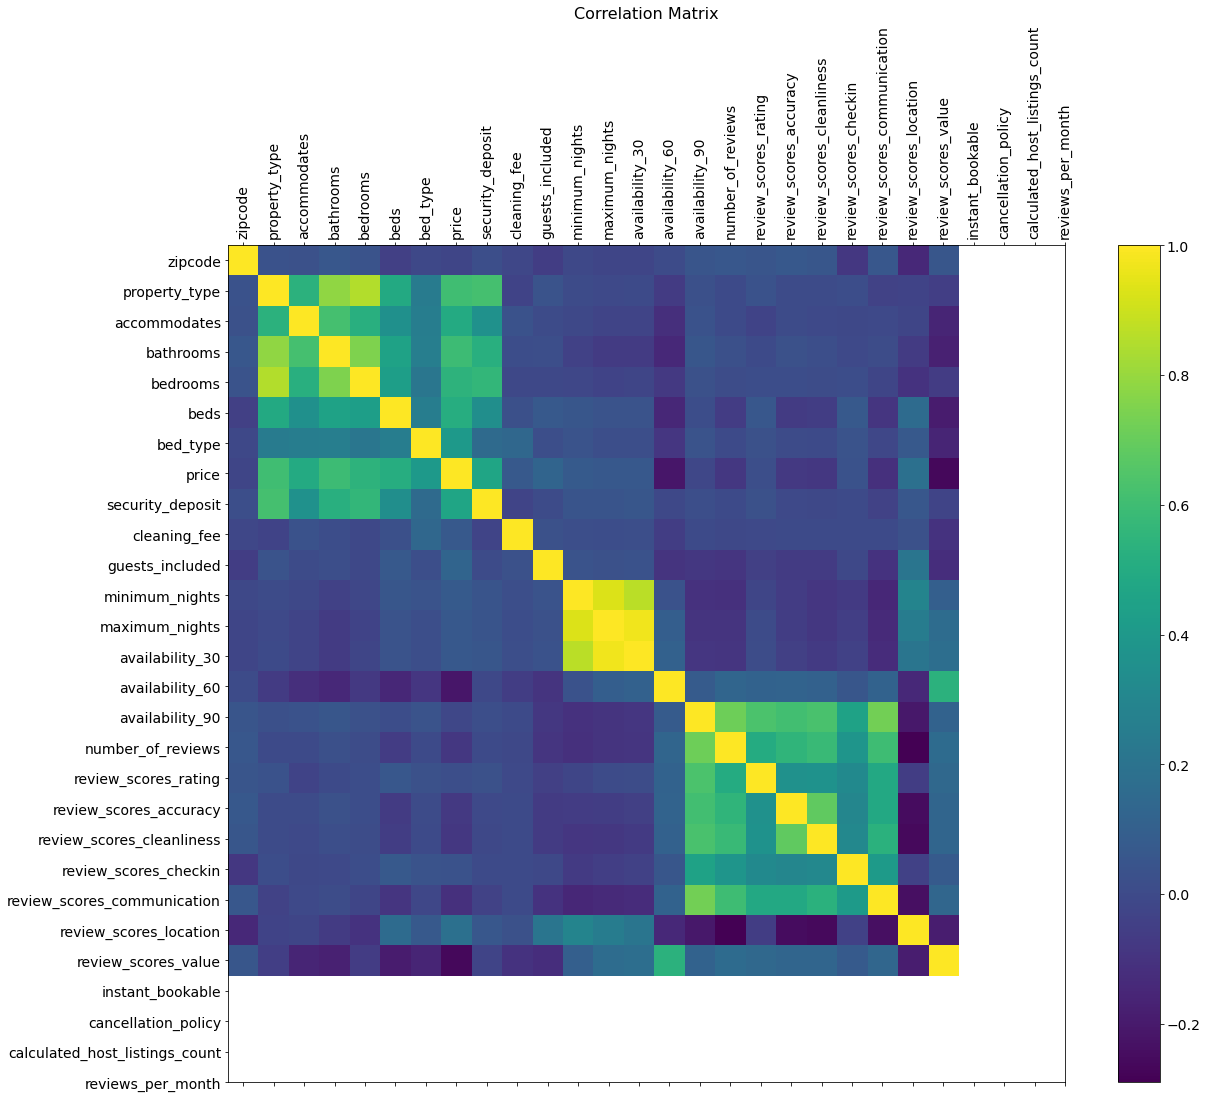

In [12]:
# plot correlation matrix between clustered neurons
 
#plt.matshow(temp3_df.corr())
f = plt.figure(figsize=(19, 15))
plt.matshow(temp3_df.corr(), fignum=f.number)
plt.xticks(range(temp3_df.shape[1]), temp3_df.columns, fontsize=14, rotation=90)
plt.yticks(range(temp3_df.shape[1]), temp3_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
plt.show()

In [ ]:
# Do more exploratory data analysis to remove outlier cases that will bias model

### Regression model to predict price from features

In [140]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing


In [141]:
# pick out a subset of features for regression model

temp4_df = temp3_df[['price','zipcode','property_type','accommodates','bathrooms','bedrooms',
                     'beds','bed_type','guests_included','review_scores_rating','instant_bookable',
                     'availability_60']]


In [142]:
# identify categorical variables for one-hot

# zipcode
print(temp4_df['zipcode'].unique())

# property_type
print(temp4_df['property_type'].unique())

# bed_type
print(temp4_df['bed_type'].unique())

# bed_type
print(temp4_df['instant_bookable'].unique())


[98122. 98115. 98106. 98103. 98108. 98101. 98136. 98126. 98121. 98107.
 98102. 98118. 98117. 98116. 98133. 98144. 98112. 98109. 98119. 98104.
 98199. 98125. 98105. 98146. 98177. 98134.    nan 98178. 98155. 98052.
 98110.]
['House' 'Guest suite' 'Apartment' 'Condominium' 'Guesthouse'
 'Bed and breakfast' 'Cabin' 'Townhouse' 'Loft' 'Bungalow' 'Cottage'
 'Boat' 'Serviced apartment' 'Castle' 'Houseboat' 'Hostel' 'Camper/RV'
 'Tent' 'Other' 'Tiny house' 'Treehouse' 'Yurt' 'Aparthotel' 'Chalet'
 'Villa' 'Lighthouse' 'Earth house' 'Boutique hotel' 'Hut' 'Resort'
 'Farm stay' 'Nature lodge' 'In-law']
['Real Bed' 'Futon' 'Pull-out Sofa' 'Airbed' 'Couch']
['t' 'f']


In [143]:
# one-hot encoding of categorical variables

temp4_df = pd.get_dummies(temp4_df, columns=['zipcode','property_type','bed_type','instant_bookable'])

del temp4_df['instant_bookable_f']

In [144]:
print(temp4_df.shape)
temp4_df.head(5)

(8695, 77)


,price,accommodates,bathrooms,bedrooms,beds,guests_included,review_scores_rating,availability_60,zipcode_98052.0,zipcode_98101.0,zipcode_98102.0,zipcode_98103.0,zipcode_98104.0,zipcode_98105.0,zipcode_98106.0,zipcode_98107.0,zipcode_98108.0,zipcode_98109.0,zipcode_98110.0,zipcode_98112.0,zipcode_98115.0,zipcode_98116.0,zipcode_98117.0,zipcode_98118.0,zipcode_98119.0,zipcode_98121.0,zipcode_98122.0,zipcode_98125.0,zipcode_98126.0,zipcode_98133.0,zipcode_98134.0,zipcode_98136.0,zipcode_98144.0,zipcode_98146.0,zipcode_98155.0,zipcode_98177.0,zipcode_98178.0,zipcode_98199.0,property_type_Aparthotel,property_type_Apartment,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Castle,property_type_Chalet,property_type_Condominium,property_type_Cottage,property_type_Earth house,property_type_Farm stay,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_House,property_type_Houseboat,property_type_Hut,property_type_In-law,property_type_Lighthouse,property_type_Loft,property_type_Nature lodge,property_type_Other,property_type_Resort,property_type_Serviced apartment,property_type_Tent,property_type_Tiny house,property_type_Townhouse,property_type_Treehouse,property_type_Villa,property_type_Yurt,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_t
0,296.0,8,2.5,4.0,4.0,8,100.0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,82.0,2,1.0,1.0,1.0,1,91.0,60,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,48.0,2,1.0,0.0,1.0,1,95.0,20,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,90.0,2,1.0,1.0,1.0,2,92.0,16,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,65.0,2,3.0,1.0,1.0,1,92.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [145]:
temp4_df = temp4_df.dropna()
print(temp4_df.shape)
temp4_df.describe()

(7627, 77)


,price,accommodates,bathrooms,bedrooms,beds,guests_included,review_scores_rating,availability_60,zipcode_98052.0,zipcode_98101.0,zipcode_98102.0,zipcode_98103.0,zipcode_98104.0,zipcode_98105.0,zipcode_98106.0,zipcode_98107.0,zipcode_98108.0,zipcode_98109.0,zipcode_98110.0,zipcode_98112.0,zipcode_98115.0,zipcode_98116.0,zipcode_98117.0,zipcode_98118.0,zipcode_98119.0,zipcode_98121.0,zipcode_98122.0,zipcode_98125.0,zipcode_98126.0,zipcode_98133.0,zipcode_98134.0,zipcode_98136.0,zipcode_98144.0,zipcode_98146.0,zipcode_98155.0,zipcode_98177.0,zipcode_98178.0,zipcode_98199.0,property_type_Aparthotel,property_type_Apartment,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Castle,property_type_Chalet,property_type_Condominium,property_type_Cottage,property_type_Earth house,property_type_Farm stay,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_House,property_type_Houseboat,property_type_Hut,property_type_In-law,property_type_Lighthouse,property_type_Loft,property_type_Nature lodge,property_type_Other,property_type_Resort,property_type_Serviced apartment,property_type_Tent,property_type_Tiny house,property_type_Townhouse,property_type_Treehouse,property_type_Villa,property_type_Yurt,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_t
count,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.0,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.0,7627.000000,7627.0,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000,7627.000000
mean,148.356497,3.650059,1.293235,1.378261,1.877803,2.022551,95.325554,27.429920,0.000131,0.062279,0.061492,0.091910,0.026485,0.049167,0.021371,0.045103,0.015865,0.061754,0.000131,0.040776,0.043530,0.027272,0.037236,0.047725,0.037629,0.055592,0.111971,0.021765,0.015865,0.015078,0.000524,0.012980,0.057165,0.002491,0.000262,0.005376,0.004065,0.020585,0.005245,0.339845,0.004065,0.002229,0.000393,0.012194,0.002098,0.001967,0.000131,0.0,0.052839,0.004327,0.000131,0.000262,0.082995,0.026878,0.000918,0.340239,0.001967,0.000131,0.000262,0.000131,0.013374,0.0,0.002491,0.0,0.017569,0.000787,0.002360,0.083388,0.000131,0.000393,0.000262,0.002491,0.000524,0.007867,0.005376,0.983742,0.493510
std,120.341690,2.245519,0.623322,0.999719,1.342487,1.647946,6.439379,21.621925,0.011450,0.241677,0.240246,0.288918,0.160583,0.216232,0.144629,0.207543,0.124960,0.240725,0.011450,0.197784,0.204059,0.162884,0.189352,0.213198,0.190311,0.229147,0.315351,0.145924,0.124960,0.121871,0.022896,0.113196,0.232173,0.049852,0.016192,0.073126,0.063628,0.141999,0.072234,0.473688,0.063628,0.047162,0.019830,0.109756,0.045757,0.044307,0.011450,0.0,0.223726,0.065640,0.011450,0.016192,0.275892,0.161738,0.030283,0.473820,0.044307,0.011450,0.016192,0.011450,0.114876,0.0,0.049852,0.0,0.131388,0.028039,0.048526,0.276486,0.011450,0.019830,0.016192,0.049852,0.022896,0.088351,0.073126,0.126475,0.499991
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [146]:
# drop availability_60 and save for later
booked_df = pd.DataFrame()
booked_df = temp4_df['availability_60'].values

del temp4_df['availability_60']

In [147]:
# min-max scale features

x = temp4_df.iloc[:,1:].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
input_df = pd.DataFrame(x_scaled)
target_df = temp4_df['price']

In [148]:
# Lasso method of feature selection selects a subset of features will attenuating coefficients of 
# less informative features to zero.

# LASSO
from sklearn import linear_model

# define features and target variable (behavioral positive bin)
x_select, y_select = input_df, target_df

# alpha value is the penalty on features (how selective do we want to be?)
alpha = 0.1 # Increasing alpha can shrink more variable coefficients to 0
clf = linear_model.Lasso(alpha=alpha,max_iter=3000)
clf.fit(x_select, y_select)

print(clf.coef_)
print(clf.intercept_)


[ 396.32866871  193.52577881  292.60119865    0.           80.47057657
   20.42904241   -0.          100.70725903   24.27892465   -0.94172425
   65.83463408   -0.          -26.9020419     0.          -16.81683154
   47.20416407    0.            7.32151375   -6.24656538    9.11481337
   -0.           -8.2453257    42.38096231   70.07096798   25.92853376
   -0.           -0.          -22.28177299    0.            0.
   -8.40597287   -0.           -0.           -1.72376651  -18.38653049
   12.39550567   -0.           -0.           -0.            0.
    0.           -0.            0.            0.            0.
    0.          -26.36513907    0.            0.            0.
   -9.07027157    3.25621949 -126.63915074  -18.61233853    0.
   -0.            0.           -0.            0.5274001     0.
   -0.            0.           49.84968771   -0.            0.
  -10.14413234   -0.            0.           -0.           -0.
    0.           -0.           -0.            4.04293169   -4.40921889

In [149]:
# pick out most informative features from LASSO feature selection

# check coeff list matches # features in x_smote
print(input_df.shape)
print(clf.coef_.shape)

# flag feature indices for features with non-zero coefficients
keep_idx = [i for i, e in enumerate(clf.coef_) if e != 0]
print(keep_idx)

# make new dataframe with subset of features for low-dimension model building
sub_X = input_df.iloc[:,keep_idx]
print(sub_X.shape)

(7627, 75)
(75,)
[0, 1, 2, 4, 5, 7, 8, 9, 10, 12, 14, 15, 17, 18, 19, 21, 22, 23, 24, 27, 30, 33, 34, 35, 46, 50, 51, 52, 53, 58, 62, 65, 73, 74]
(7627, 34)


In [150]:
# Before training our classification models, we will split our data set
# and only use 80% of the timebins to train and the remaining 20% for validation at the end

from sklearn.model_selection import train_test_split

# Separate Features from Target
X = sub_X.values   # load subselected features into X DF
#X = input_df.values    # load all features
Y = target_df.values   # Load target into Y DF

# split into a training (80%) and testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [151]:
lr = LinearRegression()
lr.fit(X_train,y_train)

# predict price for test airbnb posts
y_pred = lr.predict(X_test)

# model evaluation
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# printing values
print('Slope:' ,np.round(lr.coef_,0))
print('Intercept:', lr.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [ 396.  248.  292.   81.   27.  102.   27.   -1.   68.  -29.  -21.   48.
    7.  -11.   13.  -10.   45.   68.   21.  -26.  -11.  -25.  -50.   22.
  -31.   -9.    9. -224.  -20.   -0.   58.  -20.    8.   -8.]
Intercept: -15.049720362983663
Root mean squared error:  124.34388146181986
R2 score:  0.28571059394858356


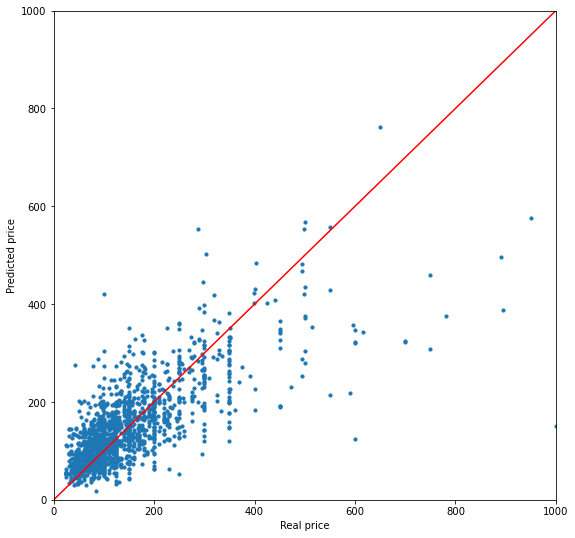

In [152]:
# plotting values

# data points
plt.subplots(figsize=(9, 9))
plt.scatter(y_test, y_pred, s=10)
plt.xlabel('Real price')
plt.ylabel('Predicted price')
plt.xlim([0, 1000])
plt.ylim([0, 1000])

# predicted values
plt.plot(range(1000),range(1000), color='r')
plt.show()

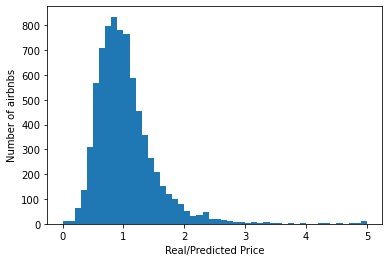

In [153]:
# categorize airbnb posts based on whether they charge differently than we modeled

resids = y_test - y_pred

# predict price of all rentals using lin reg model
y_pred_all = lr.predict(X)

price_diff = Y/y_pred_all
price_diff[price_diff>5] = 5
price_diff[price_diff<0] = 0

# plot histogram of residual ratio
plt.hist(price_diff, bins=50)
plt.xlabel('Real/Predicted Price')
plt.ylabel('Number of airbnbs')
plt.show()

#### Distribution of airbnb rental prices
Most Airbnb rentals are priced in a predictable way that fits our linear regression model. However, there is a distinct outlier population that has a much higher price than can be predicted by our standard accomodation metrics (location, rental_type, number of people accommodated). Perhaps this is due to these venues offering special experiences that are not generally included in most stays. Also, are these expensive outliers truly 'overpriced' or are they regularly booked despite their cost?

(7627,)
(7627,)


Text(0.5, 0, '% Time Booked (60 days)')

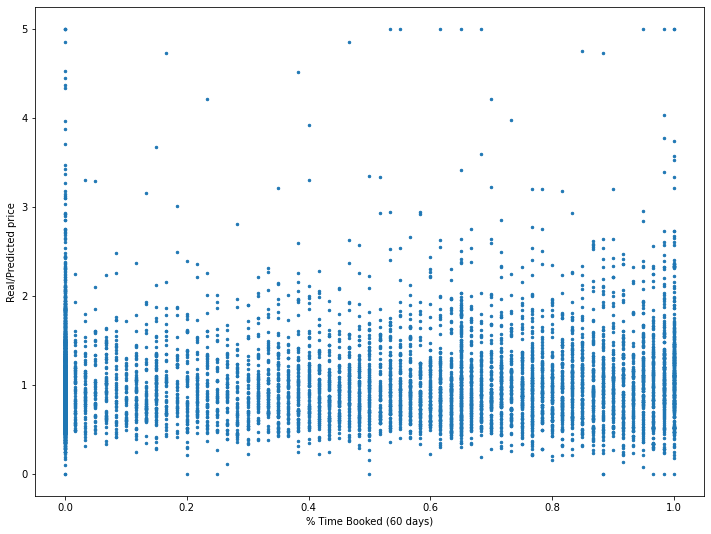

In [154]:
# Scatter plot and correlation between price difference and booking %

print(price_diff.shape)
print(booked_df.shape)

booked_perc = booked_df/60

# data points
plt.subplots(figsize=(12, 9))
plt.scatter(booked_perc,price_diff, s=6)
plt.ylabel('Real/Predicted price')
plt.xlabel('% Time Booked (60 days)')
#plt.xlim([0, 1000])
#plt.ylim([0, 1000])